# Importing modules

Let's first add these libraries to our project:

`numpy`: for matrix operations

`tensorlfow`: deep learning layers

`maplotlitb`: visualization

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py as h5
from tensorflow.python.framework import ops
from os import path
import os

# Steps for solving the problem

<ol>
    <li>Read data and format it.</li>
    <li>Use sliding window approach to augment data.</li>
    <li>Split data into training/dev/test sets.</li>
    <li>Create procedure for randomly initializing parameters with specified shape using Xavier's initialization.</li>
    <li>Create convolution and pooling procedures.</li>
    <li>Implement forward propagation.</li>
    <li>Implement cost function.</li>
    <li>Create model (uses Adam optimizer for minimization).</li>
    <li>Train model.</li>
    <li>Hyperparameter tuning using cross-validation sets.</li>
    <li>Retrain model until higher accuracy is achevied.</li>
</ol>

# Reading data

Use `dataset_relative_path` to point to the directory where the dataset after processing has been stored. 

In [2]:
dataset_relative_path = 'dataset/random-iter-1/'

In [3]:
datafile = dataset_relative_path + 'datafile512.h5'

with h5.File(datafile, 'r') as datafile:
    X_train = np.array(datafile['X_train'])
    Y_train = np.array(datafile['Y_train'])
    
    X_dev = np.array(datafile['X_dev'])
    Y_dev = np.array(datafile['Y_dev'])
    
    X_test = np.array(datafile['X_test'])
    Y_test = np.array(datafile['Y_test'])

In [4]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [5]:
X_train = make_dimensions_compatible(X_train)
X_dev = make_dimensions_compatible(X_dev)
X_test = make_dimensions_compatible(X_test)

In [6]:
print(X_train.shape)
print(Y_train.shape)

(25650, 512, 1)
(25650, 3)


### Normalization

It is a standard procedure to use normalization formula that subtracts by mean and divides by standard deviation. However, for the purpose of simplicity it won't hurt the performance of the models too much to just divide by 1000 since most of the data points are voltage measures with values ranging significantly within -1000 and 1000.

In [7]:
X_train = X_train / 1000
X_dev = X_dev / 1000
X_test = X_test / 1000

# Initialization

Deep neural networks suffer from a problem of exploding or vanishing gradients. To reduce the effect, we use Xavier's initialization which is already built into the Tensorflow.

`intiialize_parameters` receives the shapes and values of different parameters and hyper parameters to be initialized.

In [14]:
def initialize_parameters(parameter_shapes, parameter_values = {}):
    """
    Initializes weight parameters to build a neural network with tensorflow using Xaviar's initialization.
    The parameters are:
    parameter_shapes: a dictionary where keys represent tensorflow variable names, and values
    are shapes of the parameters in a list format
    Returns:
    params -- a dictionary of tensors containing parameters
    """
    
    params = { }
    
    for n,s in parameter_shapes.items():
        param = tf.get_variable(n, s, initializer = tf.contrib.layers.xavier_initializer())
        params[n] = param
    
    for n,v in parameter_values.items():
        params[n] = v
    
    return params

# Forward Propagation

Forward propagation builds most of the computation graph of the models and defines the layers for each model.

For models with different set of layers or different architecture, we define different forward propagation function. Models having similar architecture and which only differ by parameter shapes or hyper parameters share common function.

The architectures of the models we trained are described in the literature of this project.

In [15]:
def forward_propagation_cnn1(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output
    

In [16]:
def forward_propagation_cnn3(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU DROPOUT) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    # Dropout
    A2_dropped = tf.contrib.layers.dropout(A2, keep_prob=DO_prob_middle_layer, is_training=training)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2_dropped, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [17]:
def forward_propagation_cnn8(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    # Flatten activations for FC layer
    A2_flat = tf.contrib.layers.flatten(A2)
    
    # Layer 3
    # FC
    A3 = tf.contrib.layers.fully_connected(A2_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A3_dropped = tf.contrib.layers.dropout(A3, keep_prob=DO_prob, is_training=training)
    
    # Layer 4
    # FC
    logits = tf.contrib.layers.fully_connected(A3_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

# Computing cost function

We use cross entropy loss for our classification problem which takes logits from forward propagation as one of its input. The softmax layer's output from forward propagation functions defined above is not used for computing cost and is used for making predictions at the end of this notebook. The cost function of cross entropy which is built in the Tensorflow computes its own softmax.

In [18]:
def compute_cost(X, Y, parameters, nn_key, training):
    
    """
    Apply softmax to the output classes and find cross entropy loss
    X - Input data
    Y - One-hot output class training labels
    
    Returns:
    cost - cross entropy loss
    """
    
    # FIXME: setting training=training causes problems during evaluation time
    if nn_key == 'cnn1':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn2':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn3':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn4':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn5':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn6':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn7':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn8':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn9':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn10':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn11':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    else:
        KeyError('Provided nn_key doesn\'t match with any model')
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    
    return cost, Y_hat

# Pre-requisites for training

Here are some procedures that are necessary to execute before the actual training.

### Create placeholders

Tensorflow functions take input in the form of `feed_dict`. The variables in other functions are placeholders for the actual input.

In [19]:
def create_placeholders(n_x, n_y):
    """
    Creates Tensorflow placeholders that act for input data and their labels
    
    Arguments:
    n_x - no. of features for X
    n_x - no. of classes for Y
    
    Returns:
    X - placeholder for data that contains input featurs,
        shape: (no. of examples, no. of features). No. of examples is set to None
    Y - placeholder for data that contains output class labels,
        shape (no. of examples, no. of classes). No. of examples is set ot None
    """
    
    X = tf.placeholder(tf.float32, name='X', shape=(None, n_x, 1))
    Y = tf.placeholder(tf.float32, name='Y', shape=(None, n_y))
    is_train = tf.placeholder(tf.bool, name='is_train')
    
    return X,Y,is_train

### Parameter shapes

To initialize model parameters, we've created a procedure above. It takes as an argument a dictionary in which we supply the model parameter shapes.

In [20]:
def parameter_shapes(nn_key):
    """
    Get tha shapes of all parameters used in the model.
    Convolutional layer parameter shapes (filters) are in list format
    
    Arguments:
    nn_key - Provide the key for the neural network model used
    could be, 'cnn1', 'cnn2'
    
    Returns:
    param_shapes - dict that contains all the parameters as follows
    CONV1_W, CONV2_W, CONV3_W
    param_values:
    CONV1_Str, CONV2_Str, CONV3_Str,
    FC1_units, DO_prob, output_classes
    """
    
    param_shapes = {}
    param_values = {}
    
    do_prob = {
        'cnn1': 0.5,
        'cnn2': 0.7,
        'cnn3': 0.7,
        'cnn4': 0.7,
        'cnn5': 0.7,
        'cnn6': 0.9,
        'cnn7': 0.9,
        'cnn8': 0.5,
        'cnn9': 0.5,
        'cnn10': 0.7,
        'cnn11': 0.7
    }
    
    do_prob_middle_layer = {
        'cnn1': 0,   # not used
        'cnn2': 0,   # not used
        'cnn3': 0.2,
        'cnn4': 0.05,
        'cnn5': 0.01,
        'cnn6': 0,   # not used
        'cnn7': 0,   # not used
        'cnn8': 0,   # not used
        'cnn9': 0,   # not used
        'cnn10': 0,  # not used
        'cnn11': 0,  # not used
    }
    
    fc1_units = {
        'cnn1': 20,
        'cnn2': 15,
        'cnn3': 15,
        'cnn4': 15,
        'cnn5': 15,
        'cnn6': 15,
        'cnn7': 10,
        'cnn8': 20,
        'cnn9': 15,
        'cnn10': 15,
        'cnn11': 10
    }

    # Conv Layer 1 parameter shapes
    # No. of channels: 24, Filter size: 5, Stride: 3
    param_shapes['CONV1_W'] = [5, 1, 24]
    param_values['CONV1_Str'] = 3
    
    # Conv Layer 2 parameter shapes
    # No. of channels: 16, Filter size: 3, Stride: 2
    param_shapes['CONV2_W'] = [3, 24, 16]
    param_values['CONV2_Str'] = 2
    
    # Dropout after the convolutional layer 2
    # Not used in some cases
    param_values['DO_prob_middle_layer'] = do_prob_middle_layer[nn_key]
    
    # Conv Layer 3 parameter shapes
    # No. of channels: 8, Filter size: 3, Stride: 2
    param_shapes['CONV3_W'] = [3, 16, 8]
    param_values['CONV3_Str'] = 2
    
    # Fully connected layer 1 units = 20
    param_values['FC1_units'] = fc1_units[nn_key]
    
    # Dropout layer after fully connected layer 1 probability
    param_values['DO_prob'] = do_prob[nn_key]
    
    # Fully connected layer 2 units (also last layer)
    # No. of units = no. of output classes = 3
    param_values['output_classes'] = 3
    
    return param_shapes, param_values

### Random mini-batches

For each epoch we'll use different sets of mini-batches to avoid any possible overfitting.

In [21]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, window size) (m, n_x)
    Y -- output classes, of shape (number of examples, output classes) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Plotting costs

At the end of each training session, we'll plot the learning curves for training and dev sets.

In [22]:
def plot_costs(costs, dev_costs, learning_rate, total_epochs):
    # plot the cost
    plt.plot(costs, color='blue', label='training')
    plt.plot(dev_costs, color='green', label='dev')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = %f\nTotal Epochs = %i" % (learning_rate, total_epochs))
    plt.legend()
    plt.show()

# Training data

WRITE TEXT HERE...

[UPDATE_OPS](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm)

In [23]:
def model(X_train, Y_train, X_dev, Y_dev,
          learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True,
          save_session_path=None, model_file=None, restore_session=False, save_session_interval=5, max_to_keep=10,
          nn_key='cnn1'):
    """
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x,_) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    dev_costs = []
    
    model_path = None
    if (save_session_path != None and model_file != None):
        model_path = save_session_path + model_file
    
    
    # Create Placeholders of the correct shape
    X, Y, is_train = create_placeholders(n_x, n_y)

    # Initialize parameters
    param_shapes, param_values = parameter_shapes(nn_key)
    parameters = initialize_parameters(param_shapes, param_values)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Prediction: Use Y_hat to compute the output class during prediction
    cost, Y_hat = compute_cost(X, Y, parameters, nn_key, is_train)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # For saving / restoring sesison when training for long
    epoch_counter = tf.get_variable('epoch_counter', shape=[], initializer=tf.zeros_initializer)
    counter_op = tf.assign_add(epoch_counter, 1)
    saver = tf.train.Saver(max_to_keep=max_to_keep)
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Y_hat, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # For impementation of batch norm the tf.GraphKeys.UPDATE_OPS dependency needs to be added
    # see documentation on tf.contrib.layers.batch_norm
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess: #, tf.control_dependencies(update_ops):
        
        if (restore_session == False and path.exists(save_session_path)):
            raise FileExistsError('Session already exists, either restore the session, or manually delete the files.')
        
        # restore the previous session if the path already exists
        if (model_path != None and restore_session==True):
            print("Restoring session...\n")
            saver.restore(sess, model_path)
            print("Previous epoch counter: %i\n\n" % epoch_counter.eval())
        else:
            sess.run(init)
        
        tf.train.export_meta_graph(model_path + '.meta') # save the model file (.meta) only once
        
        print("Cost at start: %f" % cost.eval({X: X_train, Y: Y_train, is_train: False}))
        print("Dev cost: %f" % cost.eval({X: X_dev, Y: Y_dev, is_train: False}))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                
                try:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, is_train: True})

                    epoch_cost += minibatch_cost / num_minibatches
                
                # Implement early stopping mechanism on KeyboardInterrupt
                except KeyboardInterrupt:
                    print("KeyboardInterrupt received. Stopping early")
                    plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())
                    return parameters
                
            
            if (epoch % save_session_interval == 0 and save_session_path != None):
                saver.save(sess, model_path, write_meta_graph=False)
            
            # Save the costs after each epoch for plotting learning curve
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                dev_cost = cost.eval({X: X_dev, Y: Y_dev, is_train: False})
                dev_costs.append(dev_cost)
                
                
            # Print the cost every epoch
            if print_cost == True and (epoch + 1) % 5 == 0:
                print ("\nCost after epoch %i: %f" % (epoch + 1, epoch_cost))
                print ("Dev cost after epoch %i: %f" % (epoch + 1, dev_cost))
                
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
                dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
                print("Train Accuracy:", train_accuracy)
                print("Dev Accuracy:", dev_accuracy)
            
            # increment the epoch_counter in case the session is saved
            # and restored later
            sess.run(counter_op)
                
                
        if (save_session_path != None):
            saver.save(sess, model_path, write_meta_graph=False)
        
        
        plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())

        # Calculate the correct predictions
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
                
        return parameters
    
    

Cost at start: 1.097529
Dev cost: 1.097549
Train Accuracy: 0.2908772
Dev Accuracy: 0.328

Cost after epoch 5: 0.821053
Dev cost after epoch 5: 1.039639
Train Accuracy: 0.40074074
Dev Accuracy: 0.4

Cost after epoch 10: 0.643612
Dev cost after epoch 10: 1.190249
Train Accuracy: 0.4036647
Dev Accuracy: 0.4

Cost after epoch 15: 0.544080
Dev cost after epoch 15: 1.225363
Train Accuracy: 0.43976608
Dev Accuracy: 0.41066667

Cost after epoch 20: 0.490212
Dev cost after epoch 20: 0.899034
Train Accuracy: 0.5308382
Dev Accuracy: 0.55733335

Cost after epoch 25: 0.453740
Dev cost after epoch 25: 0.568640
Train Accuracy: 0.6902144
Dev Accuracy: 0.76266664

Cost after epoch 30: 0.419971
Dev cost after epoch 30: 0.424606
Train Accuracy: 0.82471734
Dev Accuracy: 0.81333333

Cost after epoch 35: 0.384145
Dev cost after epoch 35: 0.397766
Train Accuracy: 0.8711501
Dev Accuracy: 0.816

Cost after epoch 40: 0.356942
Dev cost after epoch 40: 0.388617
Train Accuracy: 0.89555556
Dev Accuracy: 0.848

Cost

Train Accuracy: 0.97516567
Dev Accuracy: 0.944

Cost after epoch 360: 0.143505
Dev cost after epoch 360: 0.122354
Train Accuracy: 0.9753996
Dev Accuracy: 0.94133335

Cost after epoch 365: 0.140938
Dev cost after epoch 365: 0.118495
Train Accuracy: 0.9757895
Dev Accuracy: 0.94666666

Cost after epoch 370: 0.137977
Dev cost after epoch 370: 0.118199
Train Accuracy: 0.9759454
Dev Accuracy: 0.952

Cost after epoch 375: 0.136067
Dev cost after epoch 375: 0.123297
Train Accuracy: 0.9759454
Dev Accuracy: 0.94666666

Cost after epoch 380: 0.132518
Dev cost after epoch 380: 0.119197
Train Accuracy: 0.9766082
Dev Accuracy: 0.94666666

Cost after epoch 385: 0.128820
Dev cost after epoch 385: 0.119561
Train Accuracy: 0.97621834
Dev Accuracy: 0.944

Cost after epoch 390: 0.132420
Dev cost after epoch 390: 0.118872
Train Accuracy: 0.9768421
Dev Accuracy: 0.94666666

Cost after epoch 395: 0.134018
Dev cost after epoch 395: 0.117511
Train Accuracy: 0.97692007
Dev Accuracy: 0.94666666

Cost after epoch

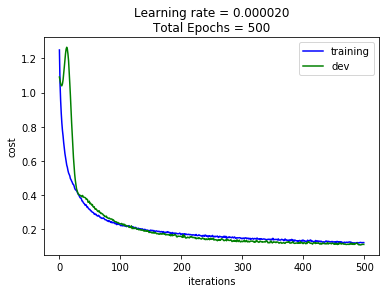

Train Accuracy: 0.9808577
Dev Accuracy: 0.9546667


In [24]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn1_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn1')

Cost at start: 1.094773
Dev cost: 1.094707
Train Accuracy: 0.25824562
Dev Accuracy: 0.25866666

Cost after epoch 5: 0.871336
Dev cost after epoch 5: 1.042187
Train Accuracy: 0.4059649
Dev Accuracy: 0.41866666

Cost after epoch 10: 0.684596
Dev cost after epoch 10: 1.007487
Train Accuracy: 0.41715398
Dev Accuracy: 0.41066667

Cost after epoch 15: 0.518856
Dev cost after epoch 15: 1.142134
Train Accuracy: 0.462846
Dev Accuracy: 0.416

Cost after epoch 20: 0.457660
Dev cost after epoch 20: 0.822131
Train Accuracy: 0.5523197
Dev Accuracy: 0.6

Cost after epoch 25: 0.409440
Dev cost after epoch 25: 0.496187
Train Accuracy: 0.7214815
Dev Accuracy: 0.776

Cost after epoch 30: 0.366064
Dev cost after epoch 30: 0.392466
Train Accuracy: 0.8202729
Dev Accuracy: 0.82133335

Cost after epoch 35: 0.324060
Dev cost after epoch 35: 0.345862
Train Accuracy: 0.87189084
Dev Accuracy: 0.84

Cost after epoch 40: 0.295590
Dev cost after epoch 40: 0.305274
Train Accuracy: 0.90269005
Dev Accuracy: 0.856

Cost

Train Accuracy: 0.9823782
Dev Accuracy: 0.96533334

Cost after epoch 360: 0.096918
Dev cost after epoch 360: 0.078518
Train Accuracy: 0.98179334
Dev Accuracy: 0.97066665

Cost after epoch 365: 0.095078
Dev cost after epoch 365: 0.075067
Train Accuracy: 0.98300195
Dev Accuracy: 0.968

Cost after epoch 370: 0.094552
Dev cost after epoch 370: 0.083264
Train Accuracy: 0.98214424
Dev Accuracy: 0.97333336

Cost after epoch 375: 0.092234
Dev cost after epoch 375: 0.076721
Train Accuracy: 0.9831189
Dev Accuracy: 0.968

Cost after epoch 380: 0.089581
Dev cost after epoch 380: 0.078854
Train Accuracy: 0.9831189
Dev Accuracy: 0.97066665

Cost after epoch 385: 0.092307
Dev cost after epoch 385: 0.073352
Train Accuracy: 0.9832359
Dev Accuracy: 0.968

Cost after epoch 390: 0.092019
Dev cost after epoch 390: 0.075855
Train Accuracy: 0.9835867
Dev Accuracy: 0.97066665

Cost after epoch 395: 0.090022
Dev cost after epoch 395: 0.077486
Train Accuracy: 0.98159844
Dev Accuracy: 0.97333336

Cost after epoc

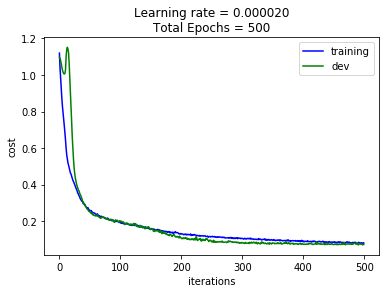

Train Accuracy: 0.98530215
Dev Accuracy: 0.97333336


In [25]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn2_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn2')

Cost at start: 1.100736
Dev cost: 1.099102
Train Accuracy: 0.38635477
Dev Accuracy: 0.37333333

Cost after epoch 5: 1.044047
Dev cost after epoch 5: 1.058047
Train Accuracy: 0.39961013
Dev Accuracy: 0.38933334

Cost after epoch 10: 0.876254
Dev cost after epoch 10: 1.005528
Train Accuracy: 0.41306043
Dev Accuracy: 0.392

Cost after epoch 15: 0.796537
Dev cost after epoch 15: 0.932694
Train Accuracy: 0.45992202
Dev Accuracy: 0.4

Cost after epoch 20: 0.758837
Dev cost after epoch 20: 0.810107
Train Accuracy: 0.5031579
Dev Accuracy: 0.52

Cost after epoch 25: 0.730875
Dev cost after epoch 25: 0.734528
Train Accuracy: 0.5511111
Dev Accuracy: 0.544

Cost after epoch 30: 0.699183
Dev cost after epoch 30: 0.688833
Train Accuracy: 0.59781677
Dev Accuracy: 0.576

Cost after epoch 35: 0.665119
Dev cost after epoch 35: 0.630605
Train Accuracy: 0.6668226
Dev Accuracy: 0.6853333

Cost after epoch 40: 0.624311
Dev cost after epoch 40: 0.562964
Train Accuracy: 0.7348148
Dev Accuracy: 0.744

Cost aft

Train Accuracy: 0.92565304
Dev Accuracy: 0.92

Cost after epoch 360: 0.274572
Dev cost after epoch 360: 0.181210
Train Accuracy: 0.9265887
Dev Accuracy: 0.92266667

Cost after epoch 365: 0.269230
Dev cost after epoch 365: 0.174419
Train Accuracy: 0.92654973
Dev Accuracy: 0.92266667

Cost after epoch 370: 0.272632
Dev cost after epoch 370: 0.176680
Train Accuracy: 0.92654973
Dev Accuracy: 0.92266667

Cost after epoch 375: 0.267607
Dev cost after epoch 375: 0.173843
Train Accuracy: 0.92709553
Dev Accuracy: 0.92

Cost after epoch 380: 0.270939
Dev cost after epoch 380: 0.171680
Train Accuracy: 0.9287719
Dev Accuracy: 0.9253333

Cost after epoch 385: 0.265709
Dev cost after epoch 385: 0.170591
Train Accuracy: 0.92904484
Dev Accuracy: 0.9253333

Cost after epoch 390: 0.271675
Dev cost after epoch 390: 0.177761
Train Accuracy: 0.92869395
Dev Accuracy: 0.9253333

Cost after epoch 395: 0.267941
Dev cost after epoch 395: 0.170632
Train Accuracy: 0.9288499
Dev Accuracy: 0.9253333

Cost after epo

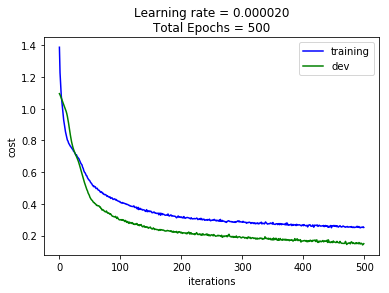

Train Accuracy: 0.9382846
Dev Accuracy: 0.93333334


In [26]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn3_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn3')

Cost at start: 1.093368
Dev cost: 1.095681
Train Accuracy: 0.20530215
Dev Accuracy: 0.19466667

Cost after epoch 5: 1.075372
Dev cost after epoch 5: 1.085069
Train Accuracy: 0.3996491
Dev Accuracy: 0.384

Cost after epoch 10: 0.989631
Dev cost after epoch 10: 1.066377
Train Accuracy: 0.4005458
Dev Accuracy: 0.392

Cost after epoch 15: 0.874920
Dev cost after epoch 15: 1.027400
Train Accuracy: 0.4194152
Dev Accuracy: 0.39466667

Cost after epoch 20: 0.794955
Dev cost after epoch 20: 0.959922
Train Accuracy: 0.46354777
Dev Accuracy: 0.40533334

Cost after epoch 25: 0.752454
Dev cost after epoch 25: 0.859454
Train Accuracy: 0.497154
Dev Accuracy: 0.50666666

Cost after epoch 30: 0.732679
Dev cost after epoch 30: 0.800886
Train Accuracy: 0.52245617
Dev Accuracy: 0.52

Cost after epoch 35: 0.717858
Dev cost after epoch 35: 0.775310
Train Accuracy: 0.5407407
Dev Accuracy: 0.528

Cost after epoch 40: 0.710797
Dev cost after epoch 40: 0.764044
Train Accuracy: 0.54994154
Dev Accuracy: 0.5306666

Train Accuracy: 0.84577
Dev Accuracy: 0.85066664

Cost after epoch 360: 0.367906
Dev cost after epoch 360: 0.350886
Train Accuracy: 0.845731
Dev Accuracy: 0.85866666

Cost after epoch 365: 0.367556
Dev cost after epoch 365: 0.350611
Train Accuracy: 0.845692
Dev Accuracy: 0.856

Cost after epoch 370: 0.370341
Dev cost after epoch 370: 0.347525
Train Accuracy: 0.8487719
Dev Accuracy: 0.85066664

Cost after epoch 375: 0.372848
Dev cost after epoch 375: 0.345332
Train Accuracy: 0.84822613
Dev Accuracy: 0.85066664

Cost after epoch 380: 0.370172
Dev cost after epoch 380: 0.342517
Train Accuracy: 0.8490058
Dev Accuracy: 0.856

Cost after epoch 385: 0.361407
Dev cost after epoch 385: 0.343338
Train Accuracy: 0.8499415
Dev Accuracy: 0.8613333

Cost after epoch 390: 0.359142
Dev cost after epoch 390: 0.339135
Train Accuracy: 0.8518519
Dev Accuracy: 0.856

Cost after epoch 395: 0.358198
Dev cost after epoch 395: 0.335998
Train Accuracy: 0.85161793
Dev Accuracy: 0.85866666

Cost after epoch 400: 

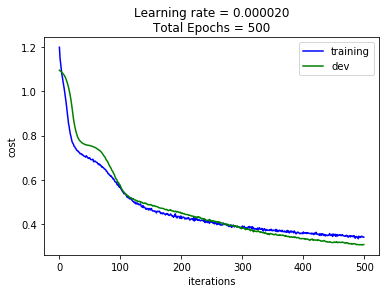

Train Accuracy: 0.86101365
Dev Accuracy: 0.8666667


In [30]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn4_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn4')

Cost at start: 1.093356
Dev cost: 1.093660
Train Accuracy: 0.228538
Dev Accuracy: 0.22666667

Cost after epoch 5: 1.103857
Dev cost after epoch 5: 1.083758
Train Accuracy: 0.4
Dev Accuracy: 0.4

Cost after epoch 10: 1.023836
Dev cost after epoch 10: 1.069100
Train Accuracy: 0.4
Dev Accuracy: 0.4

Cost after epoch 15: 0.953666
Dev cost after epoch 15: 1.044998
Train Accuracy: 0.4014425
Dev Accuracy: 0.4

Cost after epoch 20: 0.890255
Dev cost after epoch 20: 0.999068
Train Accuracy: 0.4376608
Dev Accuracy: 0.4

Cost after epoch 25: 0.838753
Dev cost after epoch 25: 0.917191
Train Accuracy: 0.4817154
Dev Accuracy: 0.52

Cost after epoch 30: 0.800841
Dev cost after epoch 30: 0.845252
Train Accuracy: 0.5145419
Dev Accuracy: 0.56

Cost after epoch 35: 0.788583
Dev cost after epoch 35: 0.804700
Train Accuracy: 0.53461987
Dev Accuracy: 0.5653333

Cost after epoch 40: 0.771004
Dev cost after epoch 40: 0.785713
Train Accuracy: 0.5437817
Dev Accuracy: 0.568

Cost after epoch 45: 0.759854
Dev cos

Train Accuracy: 0.57126707
Dev Accuracy: 0.59466666

Cost after epoch 360: 0.674957
Dev cost after epoch 360: 0.748986
Train Accuracy: 0.571384
Dev Accuracy: 0.59466666

Cost after epoch 365: 0.680519
Dev cost after epoch 365: 0.750744
Train Accuracy: 0.5694737
Dev Accuracy: 0.5973333

Cost after epoch 370: 0.678828
Dev cost after epoch 370: 0.752066
Train Accuracy: 0.5687329
Dev Accuracy: 0.5973333

Cost after epoch 375: 0.680692
Dev cost after epoch 375: 0.752274
Train Accuracy: 0.56779724
Dev Accuracy: 0.6

Cost after epoch 380: 0.675506
Dev cost after epoch 380: 0.751076
Train Accuracy: 0.56931776
Dev Accuracy: 0.5973333

Cost after epoch 385: 0.678400
Dev cost after epoch 385: 0.751953
Train Accuracy: 0.568499
Dev Accuracy: 0.6

Cost after epoch 390: 0.673826
Dev cost after epoch 390: 0.752406
Train Accuracy: 0.56635475
Dev Accuracy: 0.6

Cost after epoch 395: 0.676335
Dev cost after epoch 395: 0.751047
Train Accuracy: 0.56842107
Dev Accuracy: 0.6

Cost after epoch 400: 0.676945
D

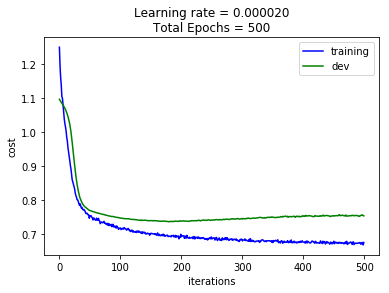

Train Accuracy: 0.55922025
Dev Accuracy: 0.6


In [31]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn5_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn5')

Cost at start: 1.101725
Dev cost: 1.100723
Train Accuracy: 0.4102534
Dev Accuracy: 0.39466667

Cost after epoch 5: 0.746966
Dev cost after epoch 5: 1.030940
Train Accuracy: 0.4003119
Dev Accuracy: 0.392

Cost after epoch 10: 0.622213
Dev cost after epoch 10: 1.177749
Train Accuracy: 0.4025731
Dev Accuracy: 0.4

Cost after epoch 15: 0.459014
Dev cost after epoch 15: 1.337996
Train Accuracy: 0.42292398
Dev Accuracy: 0.40266666

Cost after epoch 20: 0.387273
Dev cost after epoch 20: 1.149144
Train Accuracy: 0.49033138
Dev Accuracy: 0.528

Cost after epoch 25: 0.353808
Dev cost after epoch 25: 0.798367
Train Accuracy: 0.6050292
Dev Accuracy: 0.6666667

Cost after epoch 30: 0.320102
Dev cost after epoch 30: 0.485626
Train Accuracy: 0.75025344
Dev Accuracy: 0.7733333

Cost after epoch 35: 0.290852
Dev cost after epoch 35: 0.356559
Train Accuracy: 0.8357895
Dev Accuracy: 0.82666665

Cost after epoch 40: 0.261110
Dev cost after epoch 40: 0.305273
Train Accuracy: 0.88187134
Dev Accuracy: 0.8586


Cost after epoch 355: 0.088802
Dev cost after epoch 355: 0.087906
Train Accuracy: 0.97906435
Dev Accuracy: 0.976

Cost after epoch 360: 0.085654
Dev cost after epoch 360: 0.082381
Train Accuracy: 0.97984403
Dev Accuracy: 0.976

Cost after epoch 365: 0.086911
Dev cost after epoch 365: 0.082525
Train Accuracy: 0.980039
Dev Accuracy: 0.976

Cost after epoch 370: 0.084521
Dev cost after epoch 370: 0.089453
Train Accuracy: 0.97961015
Dev Accuracy: 0.97866666

Cost after epoch 375: 0.083334
Dev cost after epoch 375: 0.084827
Train Accuracy: 0.98046786
Dev Accuracy: 0.97866666

Cost after epoch 380: 0.082370
Dev cost after epoch 380: 0.095722
Train Accuracy: 0.9786745
Dev Accuracy: 0.97866666

Cost after epoch 385: 0.084623
Dev cost after epoch 385: 0.084363
Train Accuracy: 0.9810916
Dev Accuracy: 0.976

Cost after epoch 390: 0.082703
Dev cost after epoch 390: 0.084142
Train Accuracy: 0.9811306
Dev Accuracy: 0.976

Cost after epoch 395: 0.081236
Dev cost after epoch 395: 0.083694
Train Accur

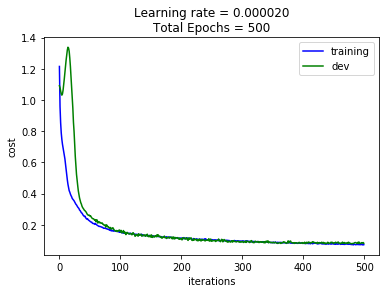

Train Accuracy: 0.9832749
Dev Accuracy: 0.976


In [32]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn6_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn6')

Cost at start: 1.101534
Dev cost: 1.100603
Train Accuracy: 0.34846005
Dev Accuracy: 0.33866668

Cost after epoch 5: 0.795354
Dev cost after epoch 5: 1.052551
Train Accuracy: 0.40015593
Dev Accuracy: 0.4

Cost after epoch 10: 0.708832
Dev cost after epoch 10: 1.154961
Train Accuracy: 0.40179336
Dev Accuracy: 0.4

Cost after epoch 15: 0.616292
Dev cost after epoch 15: 1.254320
Train Accuracy: 0.42853802
Dev Accuracy: 0.40533334

Cost after epoch 20: 0.511612
Dev cost after epoch 20: 1.054529
Train Accuracy: 0.4811306
Dev Accuracy: 0.5146667

Cost after epoch 25: 0.419900
Dev cost after epoch 25: 0.850888
Train Accuracy: 0.568577
Dev Accuracy: 0.62133336

Cost after epoch 30: 0.371825
Dev cost after epoch 30: 0.548009
Train Accuracy: 0.71321636
Dev Accuracy: 0.76

Cost after epoch 35: 0.338751
Dev cost after epoch 35: 0.396637
Train Accuracy: 0.822807
Dev Accuracy: 0.8

Cost after epoch 40: 0.320870
Dev cost after epoch 40: 0.344995
Train Accuracy: 0.86900586
Dev Accuracy: 0.84

Cost afte

Train Accuracy: 0.97567254
Dev Accuracy: 0.94133335

Cost after epoch 360: 0.096399
Dev cost after epoch 360: 0.142649
Train Accuracy: 0.97637427
Dev Accuracy: 0.94133335

Cost after epoch 365: 0.097670
Dev cost after epoch 365: 0.146858
Train Accuracy: 0.97465885
Dev Accuracy: 0.93866664

Cost after epoch 370: 0.097660
Dev cost after epoch 370: 0.145678
Train Accuracy: 0.9752047
Dev Accuracy: 0.93866664

Cost after epoch 375: 0.095285
Dev cost after epoch 375: 0.138650
Train Accuracy: 0.9768811
Dev Accuracy: 0.9493333

Cost after epoch 380: 0.093807
Dev cost after epoch 380: 0.143799
Train Accuracy: 0.9763353
Dev Accuracy: 0.94133335

Cost after epoch 385: 0.096398
Dev cost after epoch 385: 0.149080
Train Accuracy: 0.974347
Dev Accuracy: 0.93866664

Cost after epoch 390: 0.091859
Dev cost after epoch 390: 0.141024
Train Accuracy: 0.97676414
Dev Accuracy: 0.94133335

Cost after epoch 395: 0.091608
Dev cost after epoch 395: 0.144156
Train Accuracy: 0.9765302
Dev Accuracy: 0.93866664

Co

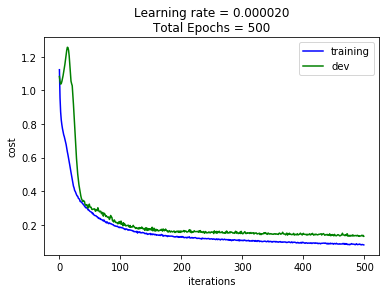

Train Accuracy: 0.9808577
Dev Accuracy: 0.94666666


In [33]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn7_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn7')

Cost at start: 1.101130
Dev cost: 1.101568
Train Accuracy: 0.32183236
Dev Accuracy: 0.344

Cost after epoch 5: 0.698574
Dev cost after epoch 5: 1.042936
Train Accuracy: 0.40019494
Dev Accuracy: 0.38933334

Cost after epoch 10: 0.531075
Dev cost after epoch 10: 1.271260
Train Accuracy: 0.40378168
Dev Accuracy: 0.40533334

Cost after epoch 15: 0.452562
Dev cost after epoch 15: 1.256378
Train Accuracy: 0.462885
Dev Accuracy: 0.43466666

Cost after epoch 20: 0.420895
Dev cost after epoch 20: 0.803145
Train Accuracy: 0.59013647
Dev Accuracy: 0.6613333

Cost after epoch 25: 0.384917
Dev cost after epoch 25: 0.516016
Train Accuracy: 0.73356724
Dev Accuracy: 0.79733336

Cost after epoch 30: 0.365123
Dev cost after epoch 30: 0.376311
Train Accuracy: 0.83216375
Dev Accuracy: 0.82133335

Cost after epoch 35: 0.348922
Dev cost after epoch 35: 0.308626
Train Accuracy: 0.8712671
Dev Accuracy: 0.84533334

Cost after epoch 40: 0.332608
Dev cost after epoch 40: 0.283521
Train Accuracy: 0.8932164
Dev Ac

Train Accuracy: 0.98101366
Dev Accuracy: 0.96

Cost after epoch 360: 0.112533
Dev cost after epoch 360: 0.104574
Train Accuracy: 0.9810916
Dev Accuracy: 0.96533334

Cost after epoch 365: 0.112031
Dev cost after epoch 365: 0.101117
Train Accuracy: 0.98046786
Dev Accuracy: 0.96533334

Cost after epoch 370: 0.113509
Dev cost after epoch 370: 0.103714
Train Accuracy: 0.98120856
Dev Accuracy: 0.9626667

Cost after epoch 375: 0.111818
Dev cost after epoch 375: 0.104024
Train Accuracy: 0.9821832
Dev Accuracy: 0.9626667

Cost after epoch 380: 0.110010
Dev cost after epoch 380: 0.102529
Train Accuracy: 0.9823002
Dev Accuracy: 0.96533334

Cost after epoch 385: 0.109553
Dev cost after epoch 385: 0.101180
Train Accuracy: 0.9821832
Dev Accuracy: 0.96533334

Cost after epoch 390: 0.110379
Dev cost after epoch 390: 0.105154
Train Accuracy: 0.982885
Dev Accuracy: 0.96

Cost after epoch 395: 0.109572
Dev cost after epoch 395: 0.111478
Train Accuracy: 0.98335284
Dev Accuracy: 0.9573333

Cost after epoch

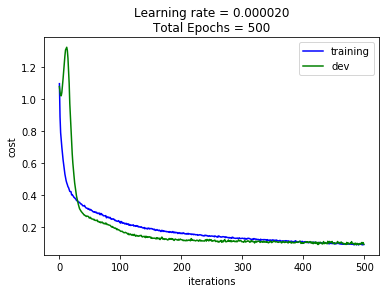

Train Accuracy: 0.9879922
Dev Accuracy: 0.9626667


In [34]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn8_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn8')

In [ ]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn9_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn9')

Cost at start: 1.094086
Dev cost: 1.094807
Train Accuracy: 0.21508773
Dev Accuracy: 0.232


In [ ]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn10_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn10')

In [ ]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn11_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn11')

# Prediction and restoring saved model

In [9]:
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        is_train = graph.get_tensor_by_name('is_train:0')
        
        epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
        print(epoch_counter.eval())

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            print('Accuracy: %f' % (y_hat_test == y_test).mean())
        

    return y_hat_test


In [10]:
def predict_voting(X_test_voting, session_path, model_file):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file
    
    y_hat_test_voting = []

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        is_train = graph.get_tensor_by_name('is_train:0')

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.gather(classname, tf.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [11]:
predictions = predict(X_test, 'train/dataset-512-1/cnn1_lr-0.00001_mbs-64/', 'model.meta', Y_test_onehot=Y_test)

print("\nPredicted values:")
print(predictions)

print("\nActual values:")
print(np.argmax(Y_test, 1))

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn1_lr-0.00001_mbs-64/model-500
500.0
Accuracy: 0.970667

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 1 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]

Actual values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

### Evaluating test set for accuracy with voting

In [13]:
testfile = dataset_relative_path + 'testset_voting_512.h5'
session_path = 'train/dataset-512-1/cnn1_lr-0.00001_mbs-64/'
model_file = 'model.meta'

with h5.File(testfile, 'r') as testfile:
    X_test_voting = testfile['X']
    X_test_voting = np.array(X_test_voting) / 1000
    y_test_voting = np.array(testfile['Y'])
    
    y_hat_test_voting = predict_voting(X_test_voting, session_path, model_file)
    
    print("Accuracy with voting: %f" % (y_test_voting == y_hat_test_voting).mean())
    

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn1_lr-0.00001_mbs-64/model-500
Accuracy with voting: 0.980000


In [ ]:
print(y_hat_test_voting)
print(y_test_voting)